In [1]:
!pip install plotly

In [2]:
!pip install statsmodels

In [3]:
!pip install missingno

In [4]:
!pip install lightgbm

In [5]:
!pip install mlxtend

## Import the required Libraries

In [6]:
import pandas as pd
import re
import os
import numpy as np
import datetime
import plotly.express as px
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split, RandomizedSearchCV

In [15]:
import zipfile
import os

# Define the folder name
extract_folder = "/content/Project/scrapped_data"

# Create the folder if it doesn't exist
os.makedirs(extract_folder, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile("raw.zip", "r") as zip_ref:
    zip_ref.extractall(extract_folder)

print(f"Files extracted to '{extract_folder}' successfully!")


Files extracted to '/content/Project/scrapped_data' successfully!


## Merge Files

In [16]:

raw_data_folder = '/content/Project/scrapped_data'  # Folder containing extracted data
merged_data_folder = '/content/Project/Data/merged'  # Folder to save merged data


if not os.path.exists(merged_data_folder):
    os.makedirs(merged_data_folder)


dataframes = []

# Loop through the files in the raw data folder
for file_name in os.listdir(raw_data_folder):
    if file_name.endswith('.csv'):
        file_path = os.path.join(raw_data_folder, file_name)

        df = pd.read_csv(file_path)
        dataframes.append(df)

# Concatenate all dataframes and keep only one header
merged_df = pd.concat(dataframes, ignore_index=True)


merged_file_path = os.path.join(merged_data_folder, 'merged_data.csv')


merged_df.to_csv(merged_file_path, index=False)

# Output the merged file path
print(f'Merged file saved at: {merged_file_path}')

Merged file saved at: /content/Project/Data/merged/merged_data.csv


## Data Pre Processing

In [17]:

df = pd.read_csv('/content/Project/Data/merged/merged_data.csv')

# Remove rows where "Car Name" is blank (NaN or empty string)
df = df[df['Car Name'].notna() & df['Car Name'].str.strip().ne('')]


df.to_csv('/content/Project/Data/merged/cleaned_merged_data.csv', index=False)


In [ ]:
df.shape

In [18]:
df = pd.read_csv('/content/Project/Data/merged/cleaned_merged_data.csv')

In [19]:

# Extract the year from 'Car Name'
df['Year'] = df['Car Name'].apply(lambda x: re.search(r'\b(19|20)\d{2}\b', x).group() if pd.notna(x) and re.search(r'\b(19|20)\d{2}\b', x) else 'Unknown')

# Extract the make and model from 'Car Name'
def extract_make_model(car_name):
    if pd.isna(car_name):  # Handle NaN cases in Car Name
        return 'Unknown', 'Unknown'

    parts = car_name.split()

    if len(parts) < 3:
        return ('Unknown', 'Unknown')

    make = parts[1]
    model = ' '.join(parts[2:])

    return make, model


df['Make'], df['Model'] = zip(*df['Car Name'].apply(extract_make_model))

# calculate (current year - car make year)
current_year = datetime.datetime.now().year

# cases where the year is not 'Unknown'
df['Age'] = df['Year'].apply(lambda x: current_year - int(x) if x.isdigit() else 'Unknown')

#  Replace non-numeric prices like 'Not Priced' with NaN, then convert 'Price' column to numeric format
df['Price_usd'] = pd.to_numeric(df['Price'].replace({'\$': '', ',': ''}, regex=True).replace('Not Priced', pd.NA), errors='coerce')

#  Convert 'Reviews' column to numeric format, remove the "reviews" text
df['Reviews'] = pd.to_numeric(df['Reviews'].replace({' reviews': '', ',': ''}, regex=True), errors='coerce')

# Convert 'Mileage' column to numeric format, remove "mi." text
df['Mileage_miles'] = pd.to_numeric(df['Mileage'].replace({' mi.': '', ',': ''}, regex=True), errors='coerce')

# Split 'Location' into 'County', 'State', and 'Distance'
df[['County', 'State_Distance']] = df['Location'].str.split(',', expand=True)
df[['State', 'Distance']] = df['State_Distance'].str.extract(r'(\w{2})\s\((\d+)\smi\.\)')
df['Distance'] = pd.to_numeric(df['Distance'], errors='coerce')  # Convert Distance to numeric


df.drop(columns=['State_Distance'], inplace=True)


df.to_csv('/content/Project/Data/processed_data.csv', index=False)


print(df[['Car Name', 'Year', 'Age']].head())


                             Car Name  Year  Age
0              2021 Ford Explorer XLT  2021    4
1             2020 Lexus UX 250h Base  2020    5
2             2022 Lexus LS 500h Base  2022    3
3             2023 Lexus LS 500h Base  2023    2
4  2016 Subaru Crosstrek 2.0i Limited  2016    9


Missing values

In [20]:
df.isnull().sum()

,0
Car Name,0
Price,0
Dealer Name,4
Transmission Type,0
Drivetrain,0
Fuel Type,0
Rating,1073
Reviews,1339
Location,914
Mileage,2


In [21]:
df.duplicated().sum()

2326

In [22]:
duplicated_rows = df[df.duplicated()]
print(duplicated_rows)
duplicated_rows.to_csv('/content/Project/Data/duplicates.csv', index=False)

                              Car Name    Price  \
21              2021 Ford Explorer XLT  $28,670   
40              2021 Ford Explorer XLT  $28,670   
43                 2017 Nissan Juke SL  $13,433   
55          2021 Subaru Ascent Limited  $30,595   
60              2021 Ford Explorer XLT  $28,670   
...                                ...      ...   
15483      2020 Kia Niro EV EX Premium  $23,490   
15506       2022 Nissan Leaf SV 40 kWh  $17,000   
15508       2024 MINI Hardtop Cooper S  $32,500   
15509     2020 Hyundai Kona EV Limited  $20,223   
15517  2021 Nissan Leaf SV PLUS 62 kWh  $18,750   

                                  Dealer Name Transmission Type  \
21                             Al Packer Ford               CVT   
40                             Al Packer Ford               CVT   
43                          Norris Auto Group               CVT   
55                                 Del Toyota               CVT   
60                             Al Packer Ford       

These include duplicate adds or the vehicles with exactly same model year etc and priced at same price by same dealer

In [23]:
df_unique = df.drop_duplicates()

In [24]:
df_unique.shape

(13215, 19)

In [25]:
df_final = df_unique.drop(columns=['Car Name', 'Price', 'Location', 'Mileage'])

In [26]:
df_final.shape

(13215, 15)

In [27]:
df_final.dtypes

,0
Dealer Name,object
Transmission Type,object
Drivetrain,object
Fuel Type,object
Rating,float64
Reviews,float64
Year,object
Make,object
Model,object
Age,int64


In [28]:
df_final.nunique()

,0
Dealer Name,930
Transmission Type,3
Drivetrain,4
Fuel Type,4
Rating,35
Reviews,603
Year,51
Make,56
Model,3058
Age,51


In [29]:
# renaming the columns

df_final = df_final.rename(columns={
    'Rating': 'Dealership Rating',
    'Reviews': 'User Reviews'
})

print(df_final.head())

                                Dealer Name Transmission Type  \
0                            Al Packer Ford               CVT   
1  Easterns Automotive Group of Glen Burnie               CVT   
2                          Len Stoler Lexus               CVT   
3                          Len Stoler Lexus               CVT   
4                      Volvo Cars Annapolis               CVT   

        Drivetrain Fuel Type  Dealership Rating  User Reviews  Year    Make  \
0  All-Wheel Drive  Gasoline                4.2        2172.0  2021    Ford   
1  All-Wheel Drive  Gasoline                4.9         728.0  2020   Lexus   
2  All-Wheel Drive  Gasoline                4.9         429.0  2022   Lexus   
3  All-Wheel Drive  Gasoline                4.9         429.0  2023   Lexus   
4  All-Wheel Drive  Gasoline                4.7        2565.0  2016  Subaru   

                    Model  Age  Price_usd  Mileage_miles        County State  \
0            Explorer XLT    4    28670.0        52968

In [30]:
unique_combinations = df_final.groupby(['Year', 'Make', 'Model']).size().reset_index(name='Count')
unique_combinations_sorted = unique_combinations.sort_values(by='Count', ascending=False)
print(unique_combinations_sorted)

      Year           Make                    Model  Count
4535  2021         Nissan                 Rogue SV     32
4931  2022            GMC     Savana 2500 Work Van     30
4972  2022          Honda              Civic Sport     30
4563  2021            RAM  1500 Big Horn/Lone Star     29
5223  2022         Nissan                Sentra SV     26
...    ...            ...                      ...    ...
17    1985  Mercedes-Benz              S-Class SEL      1
18    1986        Porsche            911 Carrera S      1
19    1987        Porsche                      911      1
20    1988          Mazda                RX-7 Base      1
21    1988        Pontiac                    Fiero      1

[6502 rows x 4 columns]


In [31]:
df_final.shape

(13215, 15)

In [32]:
df_final.describe()

,Dealership Rating,User Reviews,Age,Price_usd,Mileage_miles,Distance
count,13052.000000,12805.000000,13215.000000,13086.000000,13213.000000,12348.000000
mean,2.998920,664.359000,6.150889,29937.101483,52620.841368,43.370991
std,1.964113,1036.187907,4.871725,26355.779381,40124.166278,20.741650
min,0.000000,0.000000,0.000000,1450.000000,0.000000,5.000000
25%,0.000000,29.000000,3.000000,17998.000000,21743.000000,27.000000
50%,4.000000,298.000000,5.000000,24950.000000,43420.000000,44.000000
75%,4.600000,886.000000,8.000000,34498.000000,75663.000000,59.000000
max,5.000000,6925.000000,70.000000,549988.000000,363201.000000,150.000000


In [34]:
df_final.to_csv('/content/Project/Data/final_processed.csv', index=False)

- Data is collected in multiple files, categorized by region, fuel type, and transmission type. The initial step is merging these into a single dataset.
- The "Make," "Model," and "Year" are clustered together in one field, so they are separated into distinct columns.
- Car age is calculated based on the current year.
- Converted "Price," "Reviews," and "Mileage" to numeric values, handling non-numeric entries.
- Extracted "State" and "County" from the "Location" field.
- Removed duplicate records, which were identical ads with matching specifications and pricing from the same dealership.
- Renamed columns for clarity.

## EDA

In [35]:
categorical_columns = ['Transmission Type', 'Drivetrain', 'Fuel Type']

for col in categorical_columns:

    print(f"Category in {col} is : {df_final[col].unique()}")

Category in Transmission Type is : ['CVT' 'Automatic' 'Manual']
Category in Drivetrain is : ['All-Wheel Drive' 'Four-Wheel Drive' 'Front-Wheel Drive'
 'Rear-Wheel Drive']
Category in Fuel Type is : ['Gasoline' 'Hybrid' 'Diesel' 'Electric']


In [36]:
# Set the width and height of the figure
fig_rating = px.histogram(df_final, x='Dealership Rating', nbins=20, title='Distribution of Ratings',
                          opacity=0.85, marginal="box", color_discrete_sequence=px.colors.sequential.Viridis)

fig_rating.update_layout(title_font_size=20, title_font_color='blue',
                         width=700,
                         height=350,
                         margin=dict(l=25, r=25, t=25, b=25))
fig_rating.update_traces(marker_line_width=1.5)

fig_rating.show()


- The Dealership Rating data exhibits a positive skew, with the majority of ratings falling between 4 and 5. This suggests that dealerships generally provide satisfactory to excellent services, while poor-rated dealerships represent a small fraction

In [37]:
# Box Plot for Age of the car
fig_age = px.box(df_final, y='Age', title='Box Plot of Car Age',
                 color_discrete_sequence=px.colors.sequential.Plasma, points="all")
fig_age.update_traces(marker_color='red')
fig_age.update_layout(title_font_size=20, title_font_color='green')
fig_age.show()

In [38]:
# Fetch rows where Age is negative
negative_age_rows = df_final[df_final['Age'] < 0]

# Get distinct years from these rows
distinct_years_negative_age = negative_age_rows['Year'].unique()

# Sort the distinct years and display
distinct_years_negative_age_sorted = sorted(distinct_years_negative_age)

print("Distinct Years where Age is negative:")
print(distinct_years_negative_age_sorted)

Distinct Years where Age is negative:
[]


- The majority of cars are relatively new (with a median age of 3 years), and there are some outliers (cars up to 69 years old) that suggest the presence of rare or vintage models in the dataset.
- There are some cars with negative age(-1) , these are 2025 models. Consider encoding negative values

In [39]:
# Pie Chart for Transmission Type
fig_transmission = px.pie(df_final, names='Transmission Type', title='Transmission Types',
                          color_discrete_sequence=px.colors.qualitative.Pastel,
                          hole=0.4)


fig_transmission.update_traces(textposition='inside', textinfo='label+percent+value')
fig_transmission.update_layout(
    title_font_size=20,
    title_font_color='purple',
    legend=dict(
        x=1,
        y=1,
        traceorder="normal",
        font=dict(size=12)
    )
)

fig_transmission.show()


In [40]:
# Drivetrain with counts
fig_drivetrain = px.treemap(df_final, path=['Drivetrain'], title='Treemap of Drivetrain Types',
                            color='Drivetrain', color_discrete_sequence=px.colors.qualitative.Set3)
fig_drivetrain.update_traces(textinfo='label+value')
fig_drivetrain.update_layout(title_font_size=20, title_font_color='green')
fig_drivetrain.show()


In [41]:
# Fuel Type with counts and percentages
fig_fuel_type = px.sunburst(df_final, path=['Fuel Type'], title='Sunburst Chart of Fuel Type',
                            color='Fuel Type', color_discrete_sequence=px.colors.qualitative.Prism)


fig_fuel_type.update_traces(textinfo='label+value+percent root')


fig_fuel_type.update_layout(title_font_size=20, title_font_color='orange')


fig_fuel_type.show()

In [42]:
# Violin Plot for Price with a different color palette
fig_price = px.violin(df_final, y='Price_usd', box=True, points='all', title='Violin Plot of Car Prices',
                      color_discrete_sequence=px.colors.sequential.Turbo)

fig_price.update_layout(title_font_size=20, title_font_color='darkblue')


fig_price.show()


- The car prices have a wide range, from as low as 1,450 USD to as high as 549,988 USD.
- The majority of car prices are concentrated below 100,000 USD, as indicated by the dense region at the bottom of the plot.


In [43]:
# Filter cars priced over 200k USD
high_priced_cars = df_final[df_final['Price_usd'] > 200000]

# Get distinct makes and models
distinct_makes_models = high_priced_cars[['Make', 'Model']].drop_duplicates()

# Display the distinct makes and models
print(distinct_makes_models)

                Make                   Model
1733     Rolls-Royce  Cullinan Sport Utility
1829         Porsche      911 DESIGN EDITION
1837         Porsche           911 Turbo 3.6
2397         Porsche           911 Carrera 4
3251             BMW                 Z8 Base
3390         Porsche                 911 GT3
4678         Ferrari            296 GTB Base
4680         Ferrari           296 GTB Coupe
4681         McLaren      Artura Performance
4683         McLaren          Artura TechLux
4733     Rolls-Royce           Spectre Coupe
4734     Rolls-Royce            Spectre Base
8955         Ferrari              Roma Coupe
8978         Ferrari          Portofino Base
8999         Ferrari               Roma Base
9007     Rolls-Royce                    Dawn
9018         Porsche       718 Cayman GT4 RS
9046     Lamborghini       Huracan EVO Coupe
9068         Ferrari     296 GTS Convertible
9117     Lamborghini   Huracan Tecnica Coupe
9183         Ferrari             F430 Spider
9191      

In [44]:
# Mileage vs Price
fig_mileage_price = px.scatter(df, x='Mileage_miles', y='Price_usd', title='Mileage vs Price Scatter Plot',
                               color='Price_usd', color_continuous_scale=px.colors.sequential.Plasma, trendline='ols')
fig_mileage_price.update_traces(marker=dict(size=10, opacity=0.7))
fig_mileage_price.update_layout(title_font_size=20, title_font_color='purple')
fig_mileage_price.show()

- Mileage is inversely related to Price, meaning higher mileage tends to reduce the car’s value.
- The presence of outliers, such as luxury cars with high prices and low mileage, could affect model predictions, and may warrant further exploration or potential handling, such as feature transformation (e.g., log transformation) or outlier treatment

In [45]:
import plotly.express as px

# Sorting the median prices in descending order
median_price_per_make = df_final.groupby('Make')['Price_usd'].median().reset_index()
median_price_per_make = median_price_per_make.sort_values(by='Price_usd', ascending=False)

# Creating the bar plot
fig_median_price_make = px.bar(median_price_per_make, x='Make', y='Price_usd',
                               title='Median Car Price by Make',
                               color='Price_usd',
                               color_continuous_scale=px.colors.sequential.Viridis,
                               labels={'Price_usd': 'Median Price (USD)'})

# Updating layout
fig_median_price_make.update_layout(
    xaxis_title='Car Make',
    yaxis_title='Median Price (USD)',
    title_font_size=20,
    title_font_color='blue'
)

fig_median_price_make.show()


- Ferrari, Rolls-Royce, and McLaren are still showing the highest median prices.
- Other luxury brands like Lamborghini, Jeep, and Lexus also have relatively higher median prices.
- More common brands such as Ford, Toyota, and Chevrolet have significantly lower median car prices.

In [46]:
fig_transmission_price = px.box(df_final, x='Transmission Type', y='Price_usd',
                                title='Car Prices by Transmission Type',
                                color='Transmission Type',
                                color_discrete_sequence=px.colors.qualitative.Set2)

fig_transmission_price.update_layout(
    xaxis_title='Transmission Type',
    yaxis_title='Price (USD)',
    title_font_size=20,
    title_font_color='green'
)

fig_transmission_price.show()


- The majority of automatic cars have prices below 100k USD, with a median price of around 26.96k USD.
- The median price for CVT is around 23k USD.
- The median price for manual cars is approximately 25k USD, with some outliers priced higher.

In [47]:

fig_mileage_age = px.scatter(df_final, x='Mileage_miles', y='Age',
                             title='Mileage vs Age of Cars',
                             color='Price_usd',
                             color_continuous_scale=px.colors.sequential.Plasma)

fig_mileage_age.update_layout(
    xaxis_title='Mileage (miles)',
    yaxis_title='Age (years)',
    title_font_size=20,
    title_font_color='purple'
)

fig_mileage_age.show()


- observe that cars with ages between 20-40 years generally have miles driven between 100k and 200k miles.
- there are a few cars with very high miles driven despite being relatively new (ages 0-5 years).
- The plot also contains some older vehicles with low miles driven, which may represent well-preserved, rare, or collectible cars.

In [48]:
# average price per year
avg_price_per_year = df_final.groupby('Year')['Price_usd'].mean().reset_index()

# Line plot for average price per year
fig_avg_price_year = px.line(avg_price_per_year, x='Year', y='Price_usd',
                             title='Average Car Price per Year',
                             labels={'Price_usd': 'Average Price (USD)', 'Year': 'Year'})

fig_avg_price_year.update_layout(
    xaxis_title='Year',
    yaxis_title='Average Price (USD)',
    title_font_size=20,
    title_font_color='blue'
)

fig_avg_price_year.show()


- Cars from the 1950s to early 1960s show significantly higher average prices, likely because these vehicles are considered rare, collectible, or vintage, which increases their value. The price spike around 1960 could also indicate the presence of highly sought-after models from that era.

In [49]:
# Box plot for car prices by fuel type
fig_fuel_price = px.box(df_final, x='Fuel Type', y='Price_usd',
                        title='Car Prices by Fuel Type',
                        color='Fuel Type',
                        color_discrete_sequence=px.colors.qualitative.Set3)


fig_fuel_price.update_layout(
    xaxis_title='Fuel Type',
    yaxis_title='Price (USD)',
    title_font_size=20,
    title_font_color='blue',
    showlegend=False
)


fig_fuel_price.show()


In [50]:
# Histogram for car prices
fig_price = px.histogram(df_final, x='Price_usd', nbins=50, title='Distribution of Car Prices',
                         color_discrete_sequence=px.colors.sequential.Viridis)
fig_price.update_layout(xaxis_title="Price (USD)", yaxis_title="Count")
fig_price.show()


In [51]:
fig_transmission_price = px.box(df_final, x='Transmission Type', y='Price_usd', title="Car Prices by Transmission Type",
                                color='Transmission Type', color_discrete_sequence=px.colors.qualitative.Set2)
fig_transmission_price.update_layout(xaxis_title="Transmission Type", yaxis_title="Price (USD)")
fig_transmission_price.show()


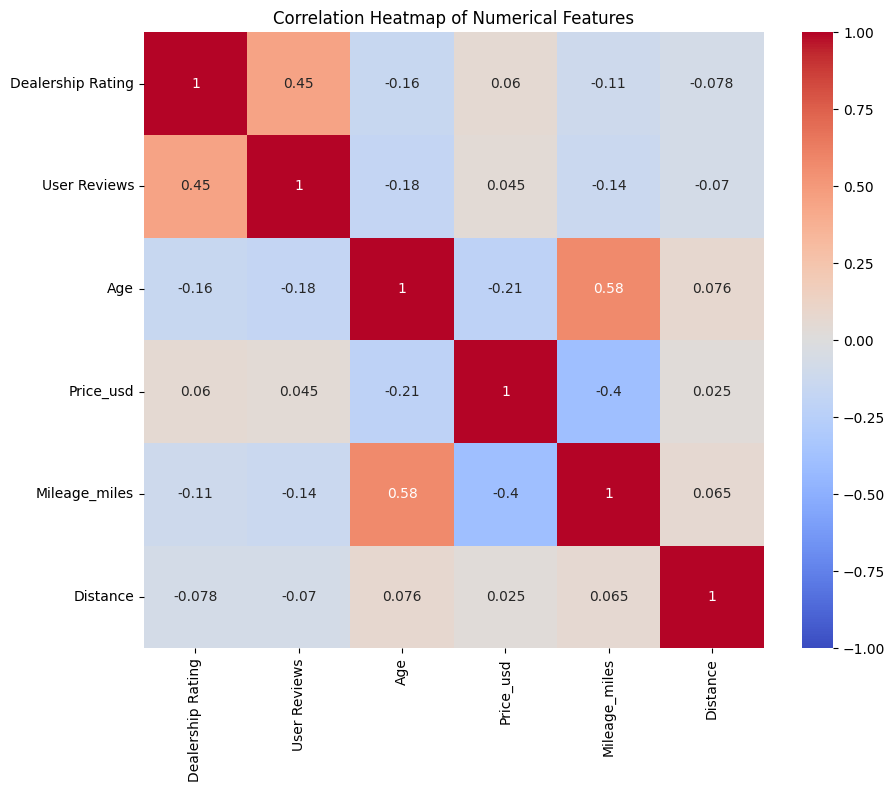

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numerical columns from the DataFrame
numerical_df = df_final.select_dtypes(include=['float64', 'int64'])


plt.figure(figsize=(10, 8))
sns.heatmap(numerical_df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()


## Feature Engineering

In [53]:
# Checking for missing values
df_final.isnull().sum()

,0
Dealer Name,2
Transmission Type,0
Drivetrain,0
Fuel Type,0
Dealership Rating,163
User Reviews,410
Year,0
Make,0
Model,0
Age,0


In [54]:
# Impute missing numerical values with the mean
df_final['Dealership Rating'].fillna(df_final['Dealership Rating'].mean(), inplace=True)
df_final['User Reviews'].fillna(df_final['User Reviews'].mean(), inplace=True)
df_final['Price_usd'].fillna(df_final['Price_usd'].mean(), inplace=True)


<ipython-input-54-9913c1ea8649>:2: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



<ipython-input-54-9913c1ea8649>:3: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[

In [55]:
# Checking for missing values
df_final.isnull().sum()

,0
Dealer Name,2
Transmission Type,0
Drivetrain,0
Fuel Type,0
Dealership Rating,0
User Reviews,0
Year,0
Make,0
Model,0
Age,0


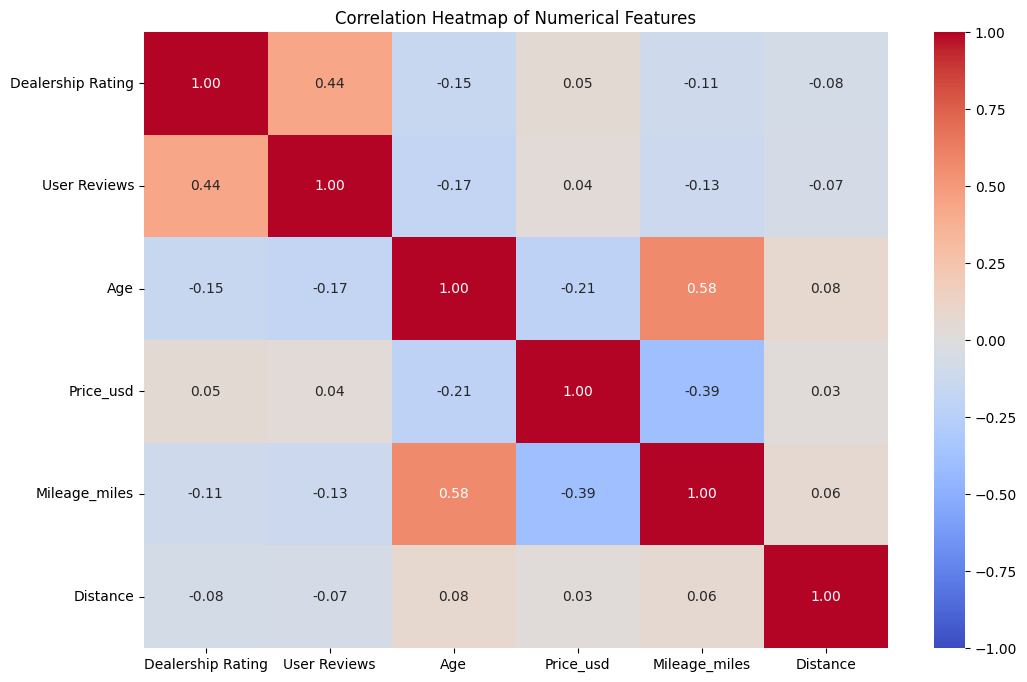

In [56]:

# Selecting only numerical columns for correlation calculation
numerical_columns = df_final.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix
correlation_matrix = numerical_columns.corr()


plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")
plt.title('Correlation Heatmap of Numerical Features')
plt.show()


Correlation of numerical features with 'Price_usd':
 Price_usd            1.000000
Dealership Rating    0.050940
User Reviews         0.037824
Distance             0.025158
Age                 -0.211233
Mileage_miles       -0.392885
Name: Price_usd, dtype: float64


<ipython-input-57-3e3113cd5edf>:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




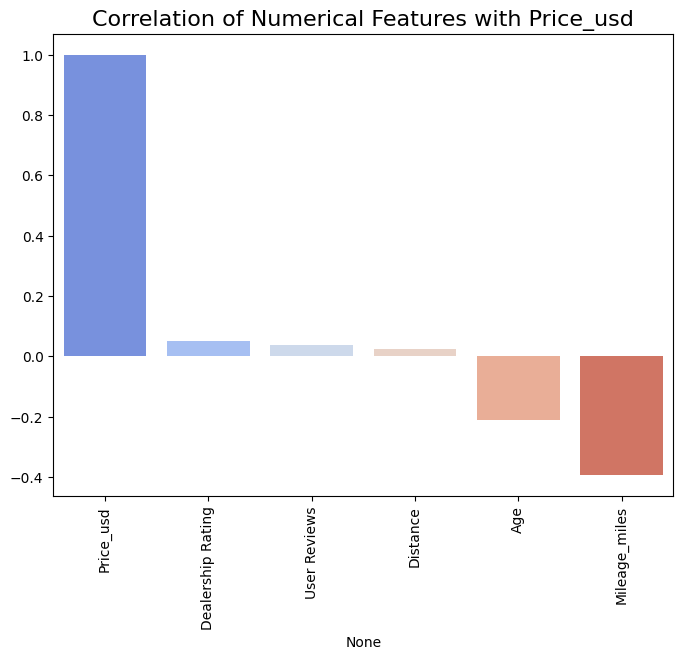

In [57]:
# Select numerical columns
numerical_columns = df_final.select_dtypes(include=['float64', 'int64'])

# Calculate correlation of all numerical features with 'Price_usd'
correlation_with_price = numerical_columns.corr()['Price_usd'].sort_values(ascending=False)

# Display the correlation with 'Price_usd'
print("Correlation of numerical features with 'Price_usd':\n", correlation_with_price)

# Plotting correlation with 'Price_usd'
plt.figure(figsize=(8, 6))
sns.barplot(x=correlation_with_price.index, y=correlation_with_price.values, palette='coolwarm')
plt.title('Correlation of Numerical Features with Price_usd', fontsize=16)
plt.xticks(rotation=90)
plt.show()


Remove Unecessary columns - 'Dealership Rating', 'User Reviews','Distance','Year'

In [58]:
df_final = df_final.drop(columns=['Dealership Rating', 'User Reviews','Distance','Year'])

In [59]:
df_final.isnull().sum()

,0
Dealer Name,2
Transmission Type,0
Drivetrain,0
Fuel Type,0
Make,0
Model,0
Age,0
Price_usd,0
Mileage_miles,2
County,864


In [60]:

# Impute missing numerical values with the median
num_imputer = SimpleImputer(strategy='median')
df_final['Mileage_miles'] = num_imputer.fit_transform(df_final[['Mileage_miles']])


## Modeling

#### Label encodind for tree based model

In [61]:
# For Tree-based models: Label Encoding
label_cols = ['Transmission Type', 'Drivetrain', 'Fuel Type', 'Make', 'Model', 'County', 'State', 'Dealer Name']
df_tree = df_final.copy()
label_encoders = {}

for col in label_cols:
    le = LabelEncoder()
    df_tree[col] = le.fit_transform(df_tree[col])
    label_encoders[col] = le

X_tree = df_tree.drop(['Price_usd'], axis=1)
y_tree = df_tree['Price_usd']

# Train-test split for tree-based models
X_train_tree, X_test_tree, y_train_tree, y_test_tree = train_test_split(X_tree, y_tree, test_size=0.2, random_state=42)


#### Defining all tree based algorithms

In [62]:
models_tree_based = {
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'XGBoost': XGBRegressor(),
    'GradientBoostingRegressor' : GradientBoostingRegressor()
}

#### Train tree based models

In [63]:
for name, model in models_tree_based.items():
    model.fit(X_train_tree, y_train_tree)
    y_pred = model.predict(X_test_tree)

    mse = mean_squared_error(y_test_tree, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_tree, y_pred)
    r2 = r2_score(y_test_tree, y_pred)
    explained_variance = explained_variance_score(y_test_tree, y_pred)

    print(f"{name} - Mean Squared Error: {mse:.4f}")
    print(f"{name} - Root Mean Squared Error: {rmse:.4f}")
    print(f"{name} - Mean Absolute Error: {mae:.4f}")
    print(f"{name} - R-squared: {r2:.4f}")
    print(f"{name} - Explained Variance: {explained_variance:.4f}")
    print("-" * 50)


Decision Tree - Mean Squared Error: 365798466.0755
Decision Tree - Root Mean Squared Error: 19125.8586
Decision Tree - Mean Absolute Error: 7720.6816
Decision Tree - R-squared: 0.5896
Decision Tree - Explained Variance: 0.5896
--------------------------------------------------
Random Forest - Mean Squared Error: 198925163.6260
Random Forest - Root Mean Squared Error: 14104.0832
Random Forest - Mean Absolute Error: 5874.6700
Random Forest - R-squared: 0.7768
Random Forest - Explained Variance: 0.7768
--------------------------------------------------
XGBoost - Mean Squared Error: 158993432.5851
XGBoost - Root Mean Squared Error: 12609.2598
XGBoost - Mean Absolute Error: 5211.1831
XGBoost - R-squared: 0.8216
XGBoost - Explained Variance: 0.8217
--------------------------------------------------
GradientBoostingRegressor - Mean Squared Error: 281021018.2071
GradientBoostingRegressor - Root Mean Squared Error: 16763.6815
GradientBoostingRegressor - Mean Absolute Error: 7778.2463
GradientBo

- Highest accuracy with tree based model is 82.2 with XGBoost

#### Linear models: One-Hot Encoding

In [64]:
# For Linear models: One-Hot Encoding
df_linear = pd.get_dummies(df_final, columns=label_cols, drop_first=True)
X_linear = df_linear.drop(['Price_usd'], axis=1)
y_linear = df_linear['Price_usd']
# Train-test split for linear models
X_train_linear, X_test_linear, y_train_linear, y_test_linear = train_test_split(X_linear, y_linear, test_size=0.2, random_state=42)


#### Define models for linear algorithms

In [65]:
models_linear = {
    'Linear Regression': LinearRegression()
}

In [66]:
# Train linear models (using One-Hot Encoded dataset)
for name, model in models_linear.items():
    model.fit(X_train_linear, y_train_linear)
    y_pred = model.predict(X_test_linear)

    mse = mean_squared_error(y_test_linear, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_linear, y_pred)
    r2 = r2_score(y_test_linear, y_pred)
    explained_variance = explained_variance_score(y_test_linear, y_pred)

    print(f"{name} - Mean Squared Error: {mse:.4f}")
    print(f"{name} - Root Mean Squared Error: {rmse:.4f}")
    print(f"{name} - Mean Absolute Error: {mae:.4f}")
    print(f"{name} - R-squared: {r2:.4f}")
    print(f"{name} - Explained Variance: {explained_variance:.4f}")
    print("-" * 50)


Linear Regression - Mean Squared Error: 177278106.1036
Linear Regression - Root Mean Squared Error: 13314.5825
Linear Regression - Mean Absolute Error: 5087.4455
Linear Regression - R-squared: 0.8011
Linear Regression - Explained Variance: 0.8011
--------------------------------------------------


#### Using Ensemble technique - Stacking Regressor with Linear Regression as Medta Model

In [67]:

# Define base models
base_models = [
    ('decision_tree', DecisionTreeRegressor()),
    ('random_forest', RandomForestRegressor()),
    ('xgboost', XGBRegressor()),
    ('gradient_boosting', GradientBoostingRegressor())
]


# Define the meta-model
meta_model = LinearRegression()

# Create Stacking Regressor
stacked_model = StackingRegressor(estimators=base_models, final_estimator=meta_model)

# Train and evaluate the stacked model
stacked_model.fit(X_train_tree, y_train_tree)
y_pred_stacked = stacked_model.predict(X_test_tree)

# Evaluation metrics for the stacked model
mse_stacked = mean_squared_error(y_test_tree, y_pred_stacked)
rmse_stacked = np.sqrt(mse_stacked)
mae_stacked = mean_absolute_error(y_test_tree, y_pred_stacked)
r2_stacked = r2_score(y_test_tree, y_pred_stacked)
explained_variance_stacked = explained_variance_score(y_test_tree, y_pred_stacked)

print("Stacked Model - Mean Squared Error:", mse_stacked)
print("Stacked Model - Root Mean Squared Error:", rmse_stacked)
print("Stacked Model - Mean Absolute Error:", mae_stacked)
print("Stacked Model - R-squared:", r2_stacked)
print("Stacked Model - Explained Variance:", explained_variance_stacked)

Stacked Model - Mean Squared Error: 158770655.73696634
Stacked Model - Root Mean Squared Error: 12600.42283961004
Stacked Model - Mean Absolute Error: 5224.549790457858
Stacked Model - R-squared: 0.8218699611440397
Stacked Model - Explained Variance: 0.8219989222240387


- Highest accuracy of 83.6 achieved using Stacking regressor with linear regression as meta model

#### Tuning hyperparameter of tree models

In [68]:
from sklearn.ensemble import StackingRegressor, GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
import numpy as np

# Define base models with initial parameters, correcting the syntax error
base_models = [
    ('decision_tree', DecisionTreeRegressor()),
    ('random_forest', RandomForestRegressor()),
    ('xgboost', XGBRegressor()),
    ('gradient_boosting', GradientBoostingRegressor())
]

# Define the meta-model
meta_model = LinearRegression()

# Create the stacking regressor
stacked_model = StackingRegressor(
    estimators=base_models,
    final_estimator=meta_model,
    passthrough=True  # Pass original features to meta-model
)

# Parameter grid for RandomizedSearchCV
param_grid = {
    # Decision Tree
    'decision_tree__max_depth': [None, 5, 10, 20],
    'decision_tree__min_samples_split': [2, 5, 10],

    # Random Forest
    'random_forest__n_estimators': [100, 200],
    'random_forest__max_depth': [None, 5, 10],
    'random_forest__min_samples_split': [2, 5],

    # XGBoost
    'xgboost__n_estimators': [100, 200],
    'xgboost__learning_rate': [0.01, 0.1, 0.2],
    'xgboost__max_depth': [3, 5, 7],

    # Gradient Boosting
    'gradient_boosting__n_estimators': [100, 200],
    'gradient_boosting__learning_rate': [0.01, 0.1, 0.2],
    'gradient_boosting__max_depth': [3, 5, 7],
    'gradient_boosting__min_samples_split': [2, 5, 10],

    # Meta-Model (Linear Regression)
    'final_estimator__fit_intercept': [True, False]
}


# Use RandomizedSearchCV for tuning
random_search = RandomizedSearchCV(
    estimator=stacked_model,
    param_distributions=param_grid,
    n_iter=20,  # Number of parameter settings that are sampled
    cv=3,       # 3-fold cross-validation
    scoring='neg_mean_squared_error',
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Fit the RandomizedSearchCV
random_search.fit(X_train_tree, y_train_tree)

# Best parameters
print("Best Parameters:")
print(random_search.best_params_)

# Evaluate the tuned model
best_model = random_search.best_estimator_
y_pred_tuned = best_model.predict(X_test_tree)

# Evaluation metrics
mse_tuned = mean_squared_error(y_test_tree, y_pred_tuned)
rmse_tuned = np.sqrt(mse_tuned)
mae_tuned = mean_absolute_error(y_test_tree, y_pred_tuned)
r2_tuned = r2_score(y_test_tree, y_pred_tuned)
explained_variance_tuned = explained_variance_score(y_test_tree, y_pred_tuned)

print("\nTuned Stacked Model Performance:")
print(f"Mean Squared Error: {mse_tuned:.4f}")
print(f"Root Mean Squared Error: {rmse_tuned:.4f}")
print(f"Mean Absolute Error: {mae_tuned:.4f}")
print(f"R-squared: {r2_tuned:.4f}")
print(f"Explained Variance: {explained_variance_tuned:.4f}")


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters:
{'xgboost__n_estimators': 200, 'xgboost__max_depth': 3, 'xgboost__learning_rate': 0.2, 'random_forest__n_estimators': 200, 'random_forest__min_samples_split': 2, 'random_forest__max_depth': 10, 'gradient_boosting__n_estimators': 200, 'gradient_boosting__min_samples_split': 5, 'gradient_boosting__max_depth': 5, 'gradient_boosting__learning_rate': 0.2, 'final_estimator__fit_intercept': False, 'decision_tree__min_samples_split': 10, 'decision_tree__max_depth': 20}

Tuned Stacked Model Performance:
Mean Squared Error: 154876563.4835
Root Mean Squared Error: 12444.9413
Mean Absolute Error: 5165.7584
R-squared: 0.8262
Explained Variance: 0.8264


- With Hyperparameter tuning achieved 84.73

##### Using different metal with tuned base tree models

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import StackingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd

# Define base models
base_models = [
     ('decision_tree', DecisionTreeRegressor(max_depth=10, min_samples_split=10)),  # Tuned parameters from previous run
    ('random_forest', RandomForestRegressor(n_estimators=200, max_depth=5, min_samples_split=2)),
    ('xgboost', XGBRegressor(n_estimators=100, max_depth=7, learning_rate=0.1)),
    ('gradient_boosting', GradientBoostingRegressor(n_estimators=200, learning_rate=0.2, max_depth=5))]

# Define meta-models and their hyperparameter grids
meta_models = {
    'Ridge': (Ridge(), {'alpha': [0.1, 1, 10, 100]}),
    'Lasso': (Lasso(), {'alpha': [0.01, 0.1, 1, 10]}),
    'Decision Tree': (DecisionTreeRegressor(), {'max_depth': [3, 5, 10], 'min_samples_split': [2, 5, 10]}),
    'Random Forest': (RandomForestRegressor(), {'n_estimators': [100, 200], 'max_depth': [3, 5, 10], 'min_samples_split': [2, 5]}),
    'XGBoost': (XGBRegressor(), {'n_estimators': [100, 200], 'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1, 0.2]}),
    'Gradient Boosting': (GradientBoostingRegressor(), {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5], 'min_samples_split': [2, 5]})
}

results = []

# Iterate over meta-models
for name, (meta_model, param_grid) in meta_models.items():
    print(f"\n--- Tuning and Evaluating {name} as the Meta-Model ---")

    # Hyperparameter tuning using RandomizedSearchCV
    search = RandomizedSearchCV(
        estimator=meta_model,
        param_distributions=param_grid,
        n_iter=20,  # Number of parameter combinations to try
        scoring='neg_mean_squared_error',
        cv=3,  # 3-fold cross-validation
        verbose=2,
        random_state=42,
        n_jobs=-1
    )
    search.fit(X_train_tree, y_train_tree)

    # Best meta-model with tuned parameters
    best_meta_model = search.best_estimator_
    print(f"Best Parameters for {name}: {search.best_params_}")

    # Create the stacking regressor with the tuned meta-model
    stacked_model = StackingRegressor(
        estimators=base_models,
        final_estimator=best_meta_model,
        passthrough=True
    )

    # Cross-validation (5-fold)
    cv_scores = cross_val_score(stacked_model, X_train_tree, y_train_tree, cv=5, scoring='r2')
    mean_cv_r2 = np.mean(cv_scores)
    print(f"Cross-validated R2: {mean_cv_r2:.4f}")

    # Train the stacking regressor on the entire training set
    stacked_model.fit(X_train_tree, y_train_tree)

    # Predict on the test set
    y_pred_stacked = stacked_model.predict(X_test_tree)

    # Evaluate the model on the test set
    mse = mean_squared_error(y_test_tree, y_pred_stacked)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_tree, y_pred_stacked)
    r2 = r2_score(y_test_tree, y_pred_stacked)
    explained_variance = explained_variance_score(y_test_tree, y_pred_stacked)

    # Print test set metrics
    print(f"Test Set R2: {r2:.4f}")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"Root Mean Squared Error: {rmse:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"Explained Variance: {explained_variance:.4f}")
    print("-" * 50)

    # Append results for comparison
    results.append({
        'Meta-Model': name,
        'CV R2': mean_cv_r2,
        'Test R2': r2,
        'Test MSE': mse,
        'Test RMSE': rmse,
        'Test MAE': mae,
        'Explained Variance': explained_variance
    })

# Save results in a DataFrame
results_df = pd.DataFrame(results)

# Display results
print("\nComparison of Meta-Models with Hyperparameter Tuning:")
print(results_df)

# Optional: Save results to a CSV file
results_df.to_csv('meta_model_results_tuned.csv', index=False)



--- Tuning and Evaluating Ridge as the Meta-Model ---
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best Parameters for Ridge: {'alpha': 10}


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning:

The total space of parameters 4 is smaller than n_iter=20. Running 4 iterations. For exhaustive searches, use GridSearchCV.



Cross-validated R2: 0.8025
Test Set R2: 0.8257
Mean Squared Error: 155317580.4344
Root Mean Squared Error: 12462.6474
Mean Absolute Error: 4979.0351
Explained Variance: 0.8260
--------------------------------------------------

--- Tuning and Evaluating Lasso as the Meta-Model ---
Fitting 3 folds for each of 4 candidates, totalling 12 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning:

The total space of parameters 4 is smaller than n_iter=20. Running 4 iterations. For exhaustive searches, use GridSearchCV.



Best Parameters for Lasso: {'alpha': 0.01}
Cross-validated R2: 0.8047
Test Set R2: 0.8305
Mean Squared Error: 151057069.5803
Root Mean Squared Error: 12290.5276
Mean Absolute Error: 4969.6937
Explained Variance: 0.8307
--------------------------------------------------

--- Tuning and Evaluating Decision Tree as the Meta-Model ---
Fitting 3 folds for each of 9 candidates, totalling 27 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning:

The total space of parameters 9 is smaller than n_iter=20. Running 9 iterations. For exhaustive searches, use GridSearchCV.



Best Parameters for Decision Tree: {'min_samples_split': 10, 'max_depth': 10}
Cross-validated R2: 0.6411
Test Set R2: 0.8244
Mean Squared Error: 156555290.1824
Root Mean Squared Error: 12512.2056
Mean Absolute Error: 5109.1975
Explained Variance: 0.8245
--------------------------------------------------

--- Tuning and Evaluating Random Forest as the Meta-Model ---
Fitting 3 folds for each of 12 candidates, totalling 36 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning:

The total space of parameters 12 is smaller than n_iter=20. Running 12 iterations. For exhaustive searches, use GridSearchCV.



Best Parameters for Random Forest: {'n_estimators': 200, 'min_samples_split': 2, 'max_depth': 10}


#### Residual Analysis

In [ ]:
residuals = y_test_tree - y_pred_stacked


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Residual Calculation
residuals = y_test_tree - y_pred_stacked

# Residuals vs Predicted Values
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_stacked, residuals, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

# Histogram of Residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# QQ Plot for Residual Normality
plt.figure(figsize=(8, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('QQ Plot of Residuals')
plt.show()

# Print Residual Metrics
print(f"Mean of Residuals: {np.mean(residuals):.4f}")


#### Residuals vs. Predicted Values
Observation: The residuals are spread out around the horizontal axis (0), but there seem to be some outliers and patterns, especially for larger predicted values.
Conclusion: While the model captures the overall trend, it might struggle with higher predictions. This could indicate heteroscedasticity (increasing variance with larger predictions).

#### Histogram of Residuals
Observation: Residuals are roughly centered around zero, but there is some skewness, and the tails are heavy.
Conclusion: The residuals are not perfectly normally distributed, which might impact the assumptions of the linear regression model  (Lasso).

#### QQ Plot
Observation: The residuals deviate significantly from the red line, especially in the tails, indicating non-normality.
Conclusion: There are extreme outliers that the model may not handle well. This could be due to unmodeled non-linear relationships or noisy data.

#### Mean of Residuals
Value: The mean of residuals is approximately -305.
Conclusion: This is close to zero, indicating no significant bias in the predictions overall, but it’s slightly off, which could be improved with further adjustments.

In [ ]:
X_train_tree.dtypes

## Stream Lit Deployment

In [ ]:
from sklearn.preprocessing import LabelEncoder
import pickle

# List of categorical columns to encode
label_cols = ['Transmission Type', 'Drivetrain', 'Fuel Type', 'County', 'State', 'Dealer Name','Model','Make']

# Create a copy of the data
df_tree_xg = df_final.copy()



# Dictionary to store LabelEncoders
label_encoders = {}

# Apply Label Encoding and store encoders
for col in label_cols:
    le = LabelEncoder()
    df_tree_xg[col] = le.fit_transform(df_tree_xg[col])
    label_encoders[col] = le

# Save the encoders to a file
with open("label_encoders.pkl", "wb") as f:
    pickle.dump(label_encoders, f)

print("Label encoders saved successfully!")

In [ ]:


X_tree_xg = df_tree_xg.drop(['Price_usd'], axis=1)
y_tree_xg = df_tree_xg['Price_usd']

# Train-test split for tree-based models
X_train_tree_xg, X_test_tree_xg, y_train_tree_xg, y_test_tree_xg = train_test_split(X_tree_xg, y_tree_xg, test_size=0.2, random_state=42)


In [ ]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Fit XGBoost model
xgboost_model = xgb.XGBRegressor(n_estimators=100, max_depth=7, learning_rate=0.1)
xgboost_model.fit(X_train_tree_xg, y_train_tree_xg)

# Feature importance
feature_importances = xgboost_model.feature_importances_

# Display feature importance
features = X_train_tree.columns
for feature, importance in zip(features, feature_importances):
    print(f"{feature}: {importance:.4f}")

# Plot feature importance
xgb.plot_importance(xgboost_model, max_num_features=10, importance_type='gain')  # Top 10 features
plt.title('XGBoost Feature Importance')
plt.show()


In [ ]:
# Generate predictions for the test set
y_pred_xgb = xgboost_model.predict(X_test_tree_xg)

# Evaluate the model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

mse = mean_squared_error(y_test_tree_xg, y_pred_xgb)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_tree_xg, y_pred_xgb)
r2 = r2_score(y_test_tree_xg, y_pred_xgb)
explained_variance = explained_variance_score(y_test_tree_xg, y_pred_xgb)

# Print evaluation metrics
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R2): {r2:.4f}")
print(f"Explained Variance: {explained_variance:.4f}")


In [ ]:
import pickle

# Save the XGBoost model
with open('xgboost_model.pkl', 'wb') as file:
    pickle.dump(xgboost_model, file)

# Save the Label Encoders (if needed for preprocessing)
with open('label_encoders.pkl', 'wb') as file:
    pickle.dump(label_encoders, file)


In [ ]:
# Load the XGBoost model
with open('xgboost_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

# Load the Label Encoders (if applicable)
with open('label_encoders.pkl', 'rb') as file:
    loaded_label_encoders = pickle.load(file)


In [ ]:
# Input values for prediction
input_data = {
    'Dealer Name': 'Auto Group Exchange',
    'Transmission Type': 'Automatic',
    'Drivetrain': 'Front-Wheel Drive',
    'Fuel Type': 'Gasoline',
    'Make': 'Toyota',
    'Model': 'Camry Hybrid SE',
    'Age': 9,
    'Mileage_miles': 50000,
    'County': 'Baltimore',
    'State': 'MD'
}

# Apply label encoding to categorical features
for col, le in loaded_label_encoders.items():
    if col in input_data:
        input_data[col] = le.transform([input_data[col]])[0]

# Create input as a DataFrame
import pandas as pd
input_df = pd.DataFrame([input_data])

# Predict the price
predicted_price = loaded_model.predict(input_df)
print(f"Predicted Car Price: ${predicted_price[0]:,.2f}")
